In [47]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import xarray as xr
from matplotlib.colors import LogNorm
from scipy.signal import stft
import zarr

plt.rcParams["font.family"] = "sans"
plt.rcParams["font.size"] = 8

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_style('darkgrid')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

import pmdarima as pm

In [49]:
shot_data = requests.get("https://mastapp.site/json/shots/30421").json()
endpoint, url = shot_data["endpoint_url"], shot_data["url"]
shot_url = url.replace("s3:/", endpoint)

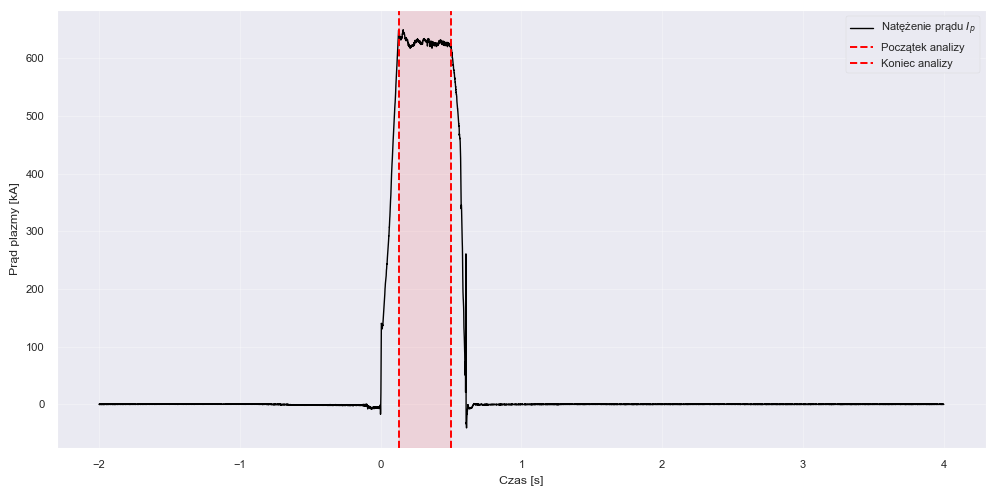

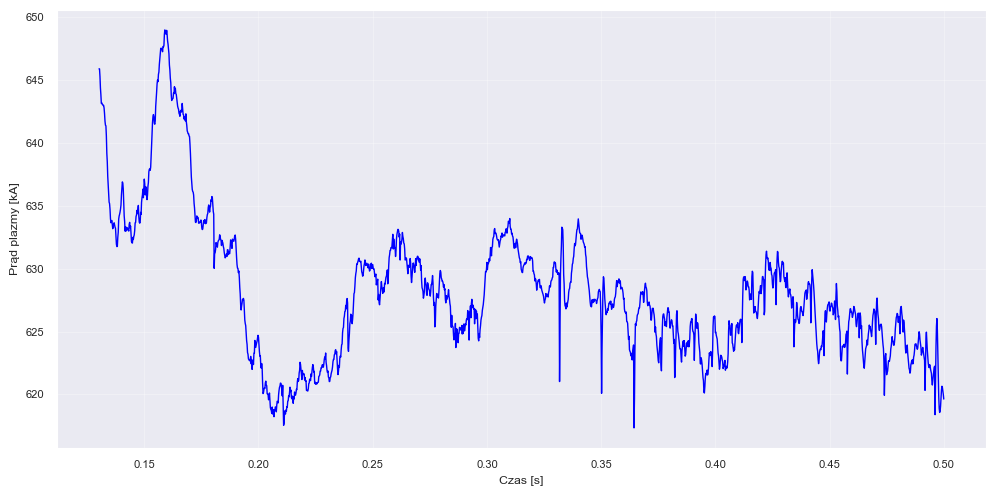

In [50]:
dataset = xr.open_zarr(shot_url, group='amc', storage_options={'ssl': False})
# dataset = dataset.isel(time=(dataset.time > 0) & (dataset.time < .35))
dataset = dataset.isel()
ts_full = dataset['plasma_current'].to_series()

start_cut = 0.13
end_cut = 0.5
mast_data = ts_full[(ts_full.index > start_cut) & (ts_full.index < end_cut)]


# RYSUNEK 1: Cały przebieg z zaznaczonym wycinkiem
plt.figure(figsize=(10, 5))
plt.plot(dataset['time'], dataset['plasma_current'], label='Natężenie prądu $I_p$', color='black', linewidth=1)

plt.axvline(x=start_cut, color='red', linestyle='--', label='Początek analizy')
plt.axvline(x=end_cut, color='red', linestyle='--', label='Koniec analizy')
plt.axvspan(start_cut, end_cut, color='red', alpha=0.1)

plt.xlabel("Czas [s]")
plt.ylabel("Prąd plazmy [kA]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("latex/figures/figure1.pdf")
plt.show()

# RYSUNEK 2: Tylko ten wycinek (mast_data)
plt.figure(figsize=(10, 5))
plt.plot(mast_data, color='blue', linewidth=1)
plt.xlabel("Czas [s]")
plt.ylabel("Prąd plazmy [kA]")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("latex/figures/figure2.pdf")
plt.show()


### ACF, ACVF, PACF dla ARMA(p, q)

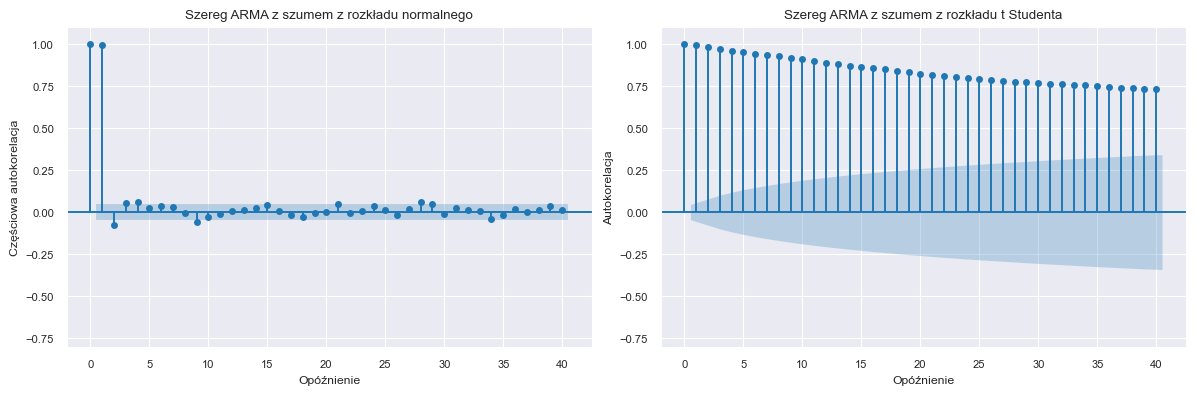

In [51]:
# Aby wyznaczyć teoretyczne wartości ACF i PAVF możemy alteratywnie skorzystać z metod acf i pacf dla wcześniej określonego obiektu "arma_process"

# acf_teor_ = arma_process.acf(lags = h_max + 1) # korzystamy z funkcji arma_acf

# pacf_teor_ = arma_process.pacf(lags = h_max + 1) # korzystamy z funkcji arma_pacf

# Aby obliczyć i zwizualizować empiryczne acf / pacf można tez skorzystać z funkcji plot_acf, plot_pacf

h_max = 40

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_pacf(mast_data, lags=h_max, ax=axes[0])
# axes[0].plot(pacf_teor_)
axes[0].set_xlabel('Opóźnienie')
axes[0].set_ylabel('Częściowa autokorelacja')
axes[0].set_title('Szereg ARMA z szumem z rozkładu normalnego')
axes[0].set_ylim(-0.8, 1.1)

plot_acf(mast_data, lags=h_max, ax=axes[1])
# axes[1].plot(acf_teor_)
axes[1].set_xlabel('Opóźnienie')
axes[1].set_ylabel('Autokorelacja')
axes[1].set_title('Szereg ARMA z szumem z rozkładu t Studenta')
axes[1].set_ylim(-0.8, 1.1)

plt.tight_layout()
plt.show()

# Aby wyznaczyć teoretyczne wartości ACVF można też skorzystać z metody acovf dla obiektu "arma_process",
# ale wówczas zostaną wyznaczone wartości dla sigma = 1

# acvf_teor_ = arma_process.acovf(nobs = h_max + 1)

### Dekompozycja szeregu czasowego - przykład 1

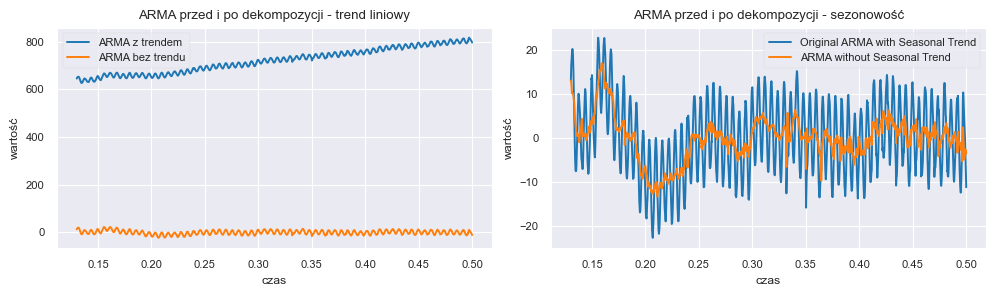

In [52]:
# Trend liniowy


trend = 0.1*np.linspace(0, len(mast_data), len(mast_data))

# Trend okresowy

period = 30
periodic_function = 10*np.sin(2 * np.pi * np.arange(len(mast_data)) / period)

mast_data_trajectory_with_components = mast_data + trend + periodic_function
time = np.arange(len(mast_data_trajectory_with_components))

# Usuwanie trendu liniowego

linear_reg = LinearRegression()
linear_reg.fit(time.reshape(-1, 1), mast_data_trajectory_with_components)
trend_predicted = linear_reg.predict(time.reshape(-1, 1))

mast_data_trajectory_without_linear_trend = mast_data_trajectory_with_components - trend_predicted

# Usuwanie funkcji okresowej

def sine_func(x, A, omega):
    return A * np.sin(omega * x)

p0 = [10, 2 * np.pi / 30]
params, _ = curve_fit(sine_func, time, mast_data_trajectory_without_linear_trend, p0=p0)
fitted_sine_wave = sine_func(time, *params)

mast_data_trajectory_without_seasonal = mast_data_trajectory_without_linear_trend - fitted_sine_wave

# Wykresy dla danych

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].plot(mast_data_trajectory_with_components, label='ARMA z trendem')
axes[0].plot(mast_data_trajectory_without_linear_trend, label='ARMA bez trendu')
axes[0].set_xlabel('czas')
axes[0].set_ylabel('wartość')
axes[0].set_title('ARMA przed i po dekompozycji - trend liniowy')
axes[0].legend()

# Plot the original ARMA process and the ARMA process without seasonal trend
axes[1].plot(mast_data_trajectory_without_linear_trend, label='Original ARMA with Seasonal Trend')
axes[1].plot(mast_data_trajectory_without_seasonal, label='ARMA without Seasonal Trend')
axes[1].set_xlabel('czas')
axes[1].set_ylabel('wartość')
axes[1].set_title('ARMA przed i po dekompozycji - sezonowość')
axes[1].legend()

plt.tight_layout()
plt.show()


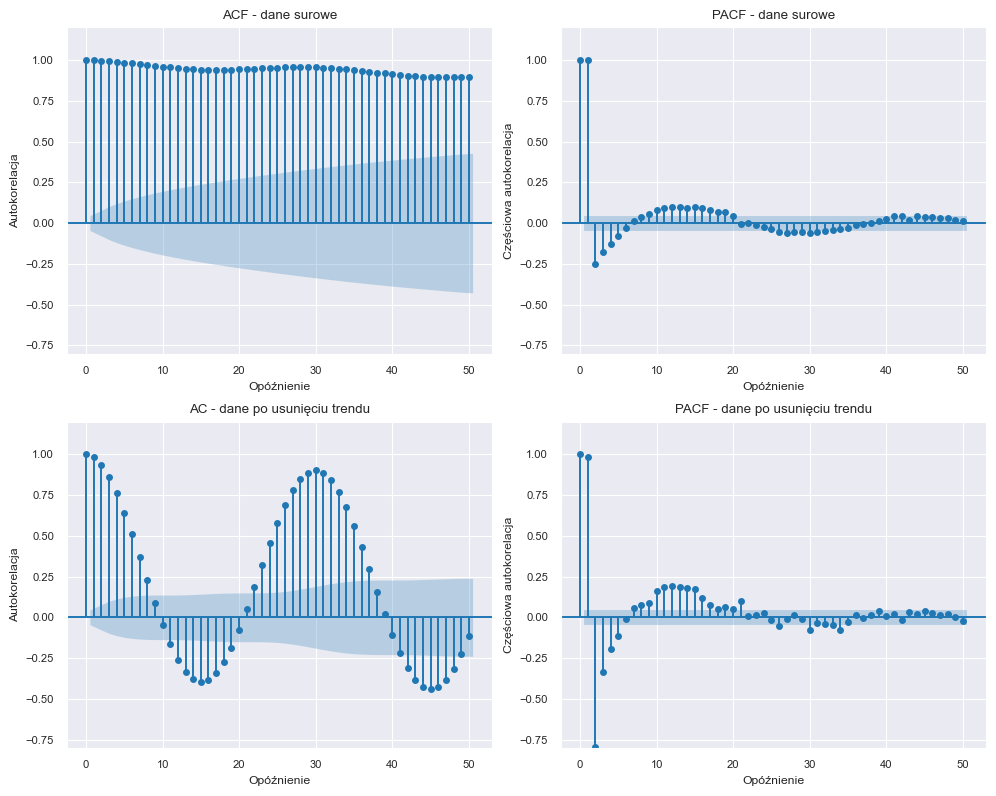

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

plot_acf(mast_data_trajectory_with_components, lags=50, ax=axes[0, 0])
axes[0, 0].set_xlabel('Opóźnienie')
axes[0, 0].set_ylabel('Autokorelacja')
axes[0, 0].set_title('ACF - dane surowe')
axes[0, 0].set_ylim(-0.8, 1.2)

plot_pacf(mast_data_trajectory_with_components, lags=50, ax=axes[0, 1])
axes[0, 1].set_xlabel('Opóźnienie')
axes[0, 1].set_ylabel('Częściowa autokorelacja')
axes[0, 1].set_title('PACF - dane surowe')
axes[0, 1].set_ylim(-0.8, 1.2)

plot_acf(mast_data_trajectory_without_linear_trend, lags=50, ax=axes[1, 0])
axes[1, 0].set_xlabel('Opóźnienie')
axes[1, 0].set_ylabel('Autokorelacja')
axes[1, 0].set_title('AC - dane po usunięciu trendu')
axes[1, 0].set_ylim(-0.8, 1.2)

plot_pacf(mast_data_trajectory_without_linear_trend, lags=50, ax=axes[1, 1])
axes[1, 1].set_xlabel('Opóźnienie')
axes[1, 1].set_ylabel('Częściowa autokorelacja')
axes[1, 1].set_title('PACF - dane po usunięciu trendu')
axes[1, 1].set_ylim(-0.8, 1.2)

plt.tight_layout()
plt.show()

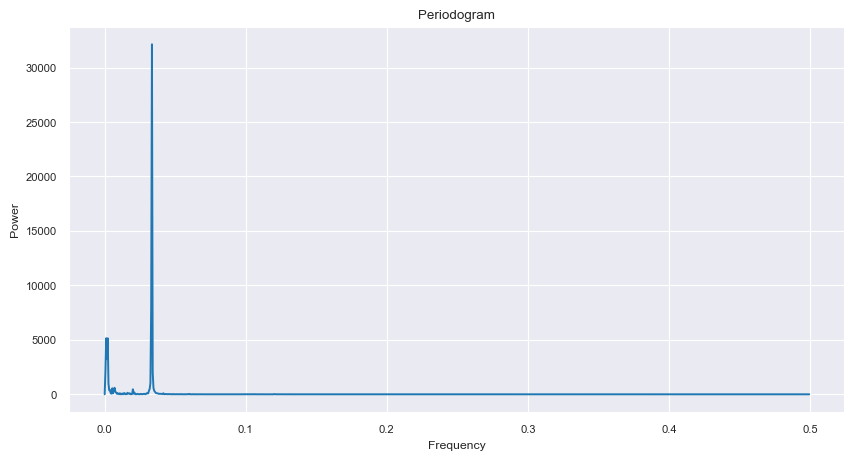

Top 5 Peaks (Frequency, Period):
Peak 1: -0.0335, -29.84
Peak 2: 0.0335, 29.84
Peak 3: 0.0330, 30.33
Peak 4: -0.0330, -30.33
Peak 5: 0.0011, 925.00
Peak 6: -0.0011, -925.00


In [54]:
# Periodogram

periodogram = np.abs(np.fft.fft(mast_data_trajectory_without_linear_trend))**2 / len(mast_data_trajectory_without_linear_trend)
frequencies = np.fft.fftfreq(len(mast_data_trajectory_without_linear_trend))

plt.figure(figsize=(10, 5))
plt.plot(frequencies[:len(mast_data_trajectory_without_linear_trend) // 2], periodogram[:len(mast_data_trajectory_without_linear_trend) // 2])
plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.show()

peak_indices = np.argsort(periodogram)[::-1][:6]
peaks_frequency = frequencies[peak_indices]
peaks_period = 1 / peaks_frequency

print("Top 5 Peaks (Frequency, Period):")
for i in range(len(peaks_frequency)):
    print(f"Peak {i+1}: {peaks_frequency[i]:.4f}, {peaks_period[i]:.2f}")